<h1 align="center"><b>CS116.M11 - LẬP TRÌNH PYTHON CHO MÁY HỌC</b></h1>
<h1 align="center"><b>BÀI TẬP 3 - NGÀY 28/09/2021</b></h1>

# **Thông tin sinh viên**

1. ***MSSV:*** 19520214
2. ***Họ tên:*** Cao Hưng Phú
3. ***Bài tập:*** Bài tập 3
4. ***Ngày thực hiện:*** 28/09/2021

# **Bài làm**

## **1. Cài đặt các thư viện cần thiết**

In [1]:
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install folium
!pip install rtree
!pip install pygeos
!pip install geojson
!pip install geopandas

In [2]:
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## **2. Clone data**

In [3]:
!git clone https://github.com/CityScope/CSL_HCMC.git

fatal: destination path 'CSL_HCMC' already exists and is not an empty directory.


## **3. Load dữ liệu dân số theo quận**

In [4]:
# Load dữ liệu
path_data = "/content/CSL_HCMC/Data/GIS/Population/population_HCMC/population_shapefile"
path_read_data = path_data + "/Population_District_Level.shp"
data = gpd.read_file(path_read_data)

# Lấy mã tọa độ
print("Mã tọa độ:", data.crs)

Mã tọa độ: epsg:32648


## **4. Load dữ liệu click của người dùng**

In [5]:
# Tải từ Google Drive
!gdown --id 1ujGzsTMeCFrSB_uAWucLCuda17OLR7NH

Downloading...
From: https://drive.google.com/uc?id=1ujGzsTMeCFrSB_uAWucLCuda17OLR7NH
To: /content/response3.json
10.0MB [00:00, 88.3MB/s]


In [6]:
# Load dữ liệu
path_user_data = "/content/response3.json"
user_data = gpd.read_file(path_user_data)

# Lấy mã tọa độ
print("Mã tọa độ:", user_data.crs)

Mã tọa độ: epsg:4326


In [7]:
# Convert sang epsg:32648
user_data = user_data.to_crs(epsg=32648)

## **5. Lấy ra top 10 quận/huyện có tốc độ tăng dân số lớn nhất (Pop_2019 / Pop_2017)**

In [8]:
# Tính tốc độ tăng dân số
data['TocDoTangDanSo'] = data['Pop_2019'] / data['Pop_2017']

In [9]:
# Xử lí bảng
dataTangDanSo = data.sort_values(by='TocDoTangDanSo', ascending=False).head(10)

In [10]:
# In kết quả
print("TOP 10 quận/huyện có tốc độ tăng dân số lớn nhất\n")
print("TOP \t Quận/Huyện \t Tốc Độ")

listDistTop10 = []

str_res = "#{} \t {} \t {:.2f}"
for i in range(len(dataTangDanSo)):
  listDistTop10.append(dataTangDanSo.iloc[i]['Dist_Name'])
  print(str_res.format(i + 1, dataTangDanSo.iloc[i]['Dist_Name'], dataTangDanSo.iloc[i]['TocDoTangDanSo']))

TOP 10 quận/huyện có tốc độ tăng dân số lớn nhất

TOP 	 Quận/Huyện 	 Tốc Độ
#1 	 District 9 	 1.28
#2 	 Hoc Mon 	 1.22
#3 	 Nha Be 	 1.16
#4 	 District 12 	 1.13
#5 	 District 2 	 1.11
#6 	 Cu Chi 	 1.10
#7 	 District 7 	 1.10
#8 	 Thu Duc 	 1.09
#9 	 Binh Chanh 	 1.08
#10 	 Binh Tan 	 1.08


## **6. Lọc các điểm click theo top 10 quận huyện này**

In [11]:
user_data_top_10 = gpd.sjoin(user_data, dataTangDanSo)

In [12]:
user_data_top_10 = user_data_top_10[['geometry', 'Dist_Name']]

In [13]:
user_data_top_10

,geometry,Dist_Name
0,POINT (687074.226 1200044.747),Thu Duc
5,POINT (691440.136 1200531.193),Thu Duc
11,POINT (691905.913 1199797.739),Thu Duc
12,POINT (691947.773 1199339.827),Thu Duc
13,POINT (691510.499 1200207.738),Thu Duc
...,...,...
77637,POINT (684294.584 1186634.720),Binh Chanh
78174,POINT (683684.190 1186844.475),Binh Chanh
79984,POINT (683579.834 1186834.975),Binh Chanh
81459,POINT (678721.460 1179200.303),Binh Chanh


## **7. Chạy thuật toán gom nhóm K-Means với K = 20**

In [14]:
# Thêm thư viện cần thiết
from sklearn.cluster import KMeans
import numpy as np

In [15]:
def convertGeometryNumpyArray(geometryData):
  geometryData = geometryData.to_numpy()
  res = []
  for point in geometryData:
    res.append([point.x, point.y])
  return np.array(res)

In [16]:
def getKMeanMaxWithDist(data, dist):
  # Lọc data theo quận
  temp_data = data.loc[data['Dist_Name'] == dist]
  # Chạy KMean
  X = convertGeometryNumpyArray(temp_data['geometry'])
  kmeans = KMeans(n_clusters=20, random_state=0).fit(X)
  # Sắp xếp lấy label cao nhất
  listLabels = (kmeans.labels_).tolist()
  countLabels = [(i, listLabels.count(i)) for i in range(max(listLabels)+1)]
  countLabelsSorted = sorted(countLabels, key=lambda countLabels: countLabels[1], reverse=True)
  maxLabel = countLabelsSorted[0][0]
  # Trả về giá trị max label count
  return kmeans, maxLabel

## **8. Lấy ra cụm điểm click gom nhóm nhiều nhất của mỗi quận/huyện**

In [17]:
def getPredictKMeanLabel(kmeans, point):
  return kmeans.predict([[point.x, point.y]])[0]

def getClickDataWithDist(data, dist):
  temp_data = data.copy()
  # Lọc data theo quận
  temp_data = temp_data.loc[data['Dist_Name'] == dist]
  # Get kmean + max label
  kmeans, maxlabel = getKMeanMaxWithDist(temp_data, dist)
  # Tính label
  temp_data['label'] = temp_data.apply(lambda x: getPredictKMeanLabel(kmeans, x['geometry']), axis=1)
  return temp_data.loc[temp_data['label'] == maxlabel][['geometry']]

In [18]:
listClickData = []
for distName in listDistTop10:
  listClickData.append(getClickDataWithDist(user_data_top_10, distName))

## **9. Vẽ biểu đồ heatmap với thư viện folium các cụm điểm lớn nhất theo từng quận/huyện này**

In [19]:
import folium
import shapely
from folium import plugins
from folium.plugins import HeatMap

In [20]:
point_centroid = shapely.geometry.polygon.Polygon(list(data['geometry'].to_crs(epsg=4326).apply(lambda polygon: polygon.centroid))).centroid

m = folium.Map(location=[point_centroid.y, point_centroid.x], zoom_start=10, tiles='CartoDB positron')
data_main = data.to_crs(epsg=4326)

# Load ranh giới
for _, r in data_main.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Dist_Name']).add_to(geo_j)
    geo_j.add_to(m)


# Head map
heatData = []
for clickData in listClickData: 
  heatData += list(map(lambda point: (point.y, point.x), clickData.to_crs(epsg=4326)['geometry'].values))
HeatMap(heatData, radius=20).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))

m

## **10. Lưu heatmap ra file PNG**

### **10.1. Cách 1: Dùng Selenium**

In [21]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

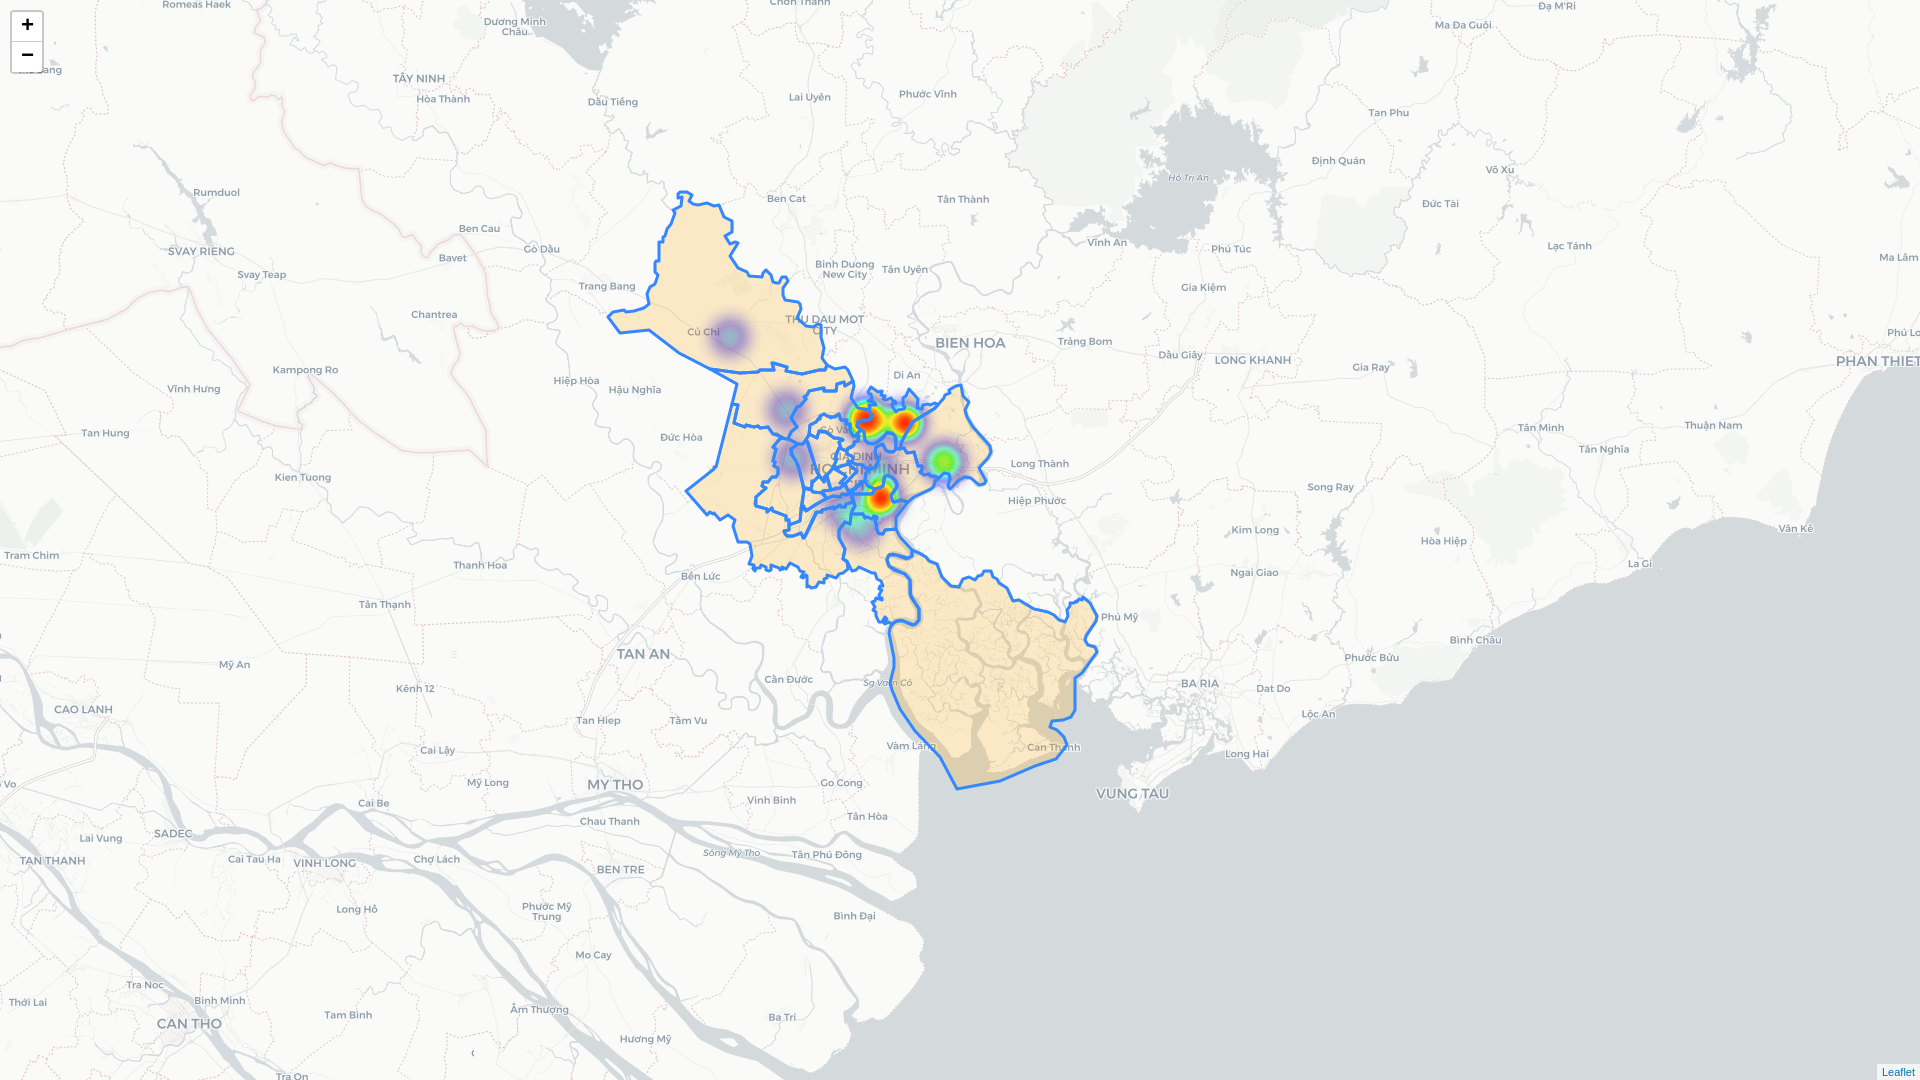

In [24]:
import os
import time
import sys
from selenium import webdriver
import cv2
from google.colab.patches import cv2_imshow

html_file = 'result.html'
image_file = 'result.png'
url = 'file://{}/{}'.format(os.getcwd(), html_file)

m.save(html_file)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome('chromedriver', options=options)
driver.get(url);

time.sleep(5)
driver.save_screenshot(image_file)
driver.quit()

cv2_imshow(cv2.imread(image_file))

### **10.2. Cách 2: Gọi API**

In [25]:
# Cài thư viện
!pip install convertapi

In [26]:
# Gán path file
path_html_file = '/content/result.html'
path_image_save = '/content/'
path_image_file = '/content/result.png'

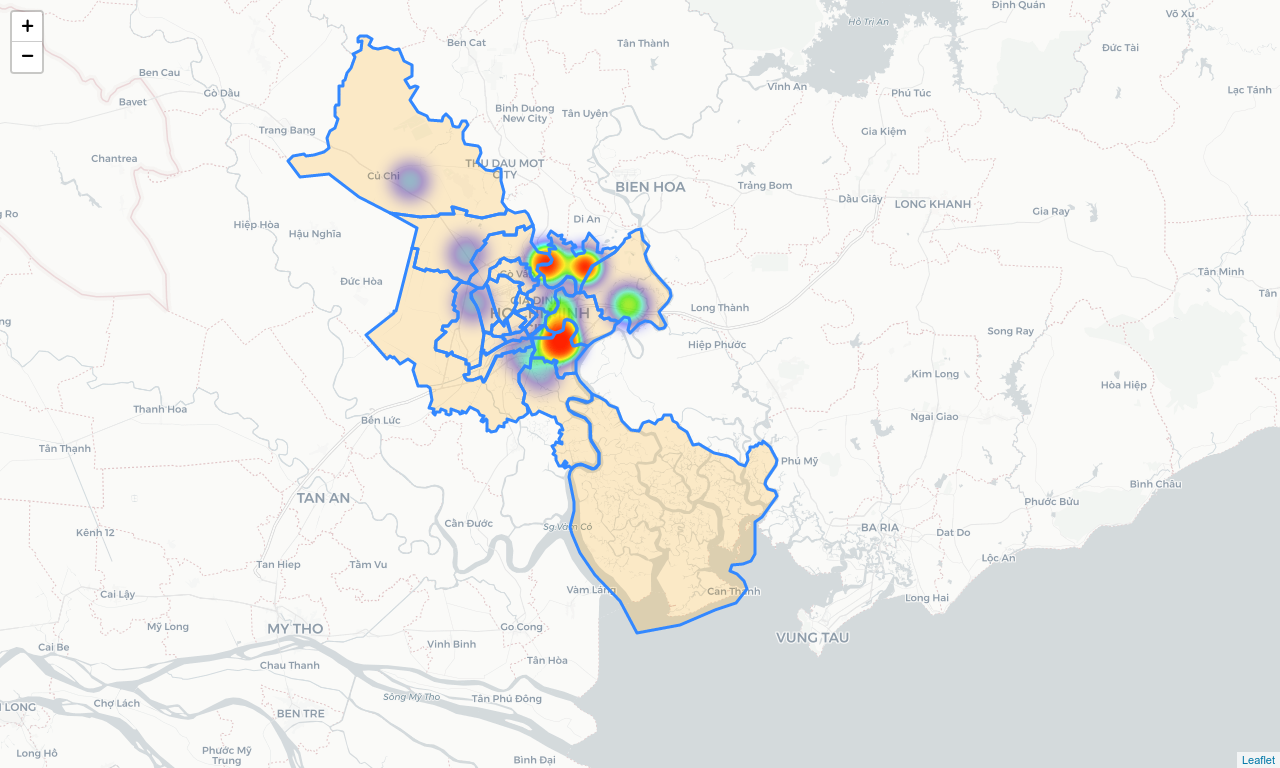

In [27]:
# Convert API
import convertapi

convertapi.api_secret = '8UrCC1iOKhDbDRWQ'
convertapi.convert('png', {
    'File': path_html_file,
    'ConversionDelay': 5
}, from_format = 'html').save_files(path_image_save)

cv2_imshow(cv2.imread(image_file))